# Aster Centering Analysis - Day 2
***
<i> Dmitrief, Turlier, De Labbey, Badaoui </i> </br>
<i> ENS - Active Matter  Workshop - Feb 22 </i>

In this notebook, we use Cytosim Analysis to analyze a Simulation where an Aster autonomously moves to the center.

## Imports

In [33]:
#Classic Import

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as npl
import pandas as pd
import sys
import os 

#Cytolysis Import

from cytolysis import cytosim_analysis as ana
from cytolysis.objects import Object, Object_set

import sio_tools as sio


from aster import Aster_set
from methods import distance, colin, total_force, total_individual_forces, tweezer_distance


In [34]:
#PARAMETERS

frame_step = 1

#PATH

from pathlib import Path
current_path = str(Path().absolute()) 
path_simu = current_path  + '/simu'

## <u> Vesicule Pulling </u>

Here, we would like to investigate an other possible mechanism based on pulling.  

For this example, we deal with motors which can bind both to cytoplasmic vesicules and microtubules. Thus, by to linking them, they can generate forces which could center the system.

### <i> <u> First Part - Position </u> </i>
<i>First We will check the Position of The Aster</i>.

**Q1. Run the simulation with the config file in `/pulling/example_pulling` by using the `sim` command.**:

* `cytosim-sim config.cym `

**Q2. Report the characteristic of the Aster with the `report` command applied to:**

* ` cytosim-report aster:force > force.txt`
* ` cytosim-report aster:links > links.txt`

**Q3. Check the files consistency and use the `cytosim_analysis` package to analyze the report files.**

*NB : You should get a Pandas DataFrame summarizing all the important quantitites.*

In [38]:
def cytosim_analysis_function(path_in):
    

    # REPORT FILES

    #Aster
    solid_file = path_in + "/force.txt" #Force for the Aster
    link_file = path_in + "/links.txt" #Links for the Aster

    #Config
    config_file = path_in + "/config.cym" #Config File

    # DICTIONNARY

    #Solid
    solids =   {"force": solid_file, "link": link_file}
    solid_opts = {"type" : "solid" , "set" : Aster_set}

    # CREATE SIMULATION INSTANCE

    simul = ana.Simulation(solid_report={"core": solids},
                           solid_options=solid_opts,
                           config=config_file, dim=2)

    # ANALYSIS FUNCTION DECLARATION

    analyzer={"distance": distance, 
              "colin": colin , 
              "total_force":total_force, 
              "total_individual_forces":total_individual_forces} 

    # ANALYSIS

    simul.make_analysis(frame_analyzer=analyzer)
    analysis=simul.frames_analysis
    
    return analysis


In [39]:
folder_test = '/pulling/example_pulling'

df_analysis = cytosim_analysis_function(path_simu + folder_test)
df_analysis
distance_aster = df_analysis['distance']

**Q4. Is the Aster Centering ?**
* **A. Plot the distance to the center with respect to the time and check the stability of it.**
* **B. You can help yourself with the `play` command on Cytosim.**

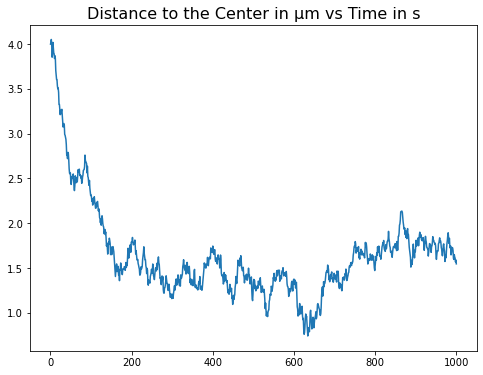

In [40]:
#PLOTS

#Centration of The Aster

plt.figure(figsize =(8,6))

plt.plot(df_analysis["id"]*frame_step,distance_aster,label="Distance to the Center")

plt.title('Distance to the Center in µm vs Time in s',size =16)
plt.show()


**C. If it is not centering, what do you suggest to permit it ?**

* Increase the number of motors ?

You can tweak the parameters on the `/pulling/example_pulling_centering/config.cym` file and restart !


### <i> <u> Second Part - Colinear Force </u></i>

As you might have realised those simulations are taking time, as we have to compute tje position of the motors trough time.

On possibility, to simplify the whole procces with a simplier model is to consider the 

### <i> <u> Third Part - Force - Tweezer </u></i>
<i>One way to quantify te stability of the Aster Positionning is to measure the force with respect to the position, to conclude whether or not the position is a stable fixed point.
</i>

To do so, we will use configuration templates and work in the `pulling_tweezers` directory with template `config_tpl.cym`:

Here we are directly going to play with the Tweezers to preciseley probe the Force-Position relationshop for an Aster centering thanks to vesicule pulling.

``` 
[[ x = [-9 + i for i in range(19)]]]

set space tweezer
{
    shape = tweezer
}

new tweezer
{
    center = ( [[x]] 0 )
}
```

**Q9. Just like yesterday, follow these steps to generate config files, run simulations and report stuff**  

* Generate config files

  `../../../python/run/preconfig.py config_tpl.cym`
  

* Place in separated directories

  `mkdir files`  
  `mv config_tpl*.cym ./files`
  
  
* Run simulations

  `../../../python/run/go_sim.py ../../../bin/sim ./files/config_tpl*.cym njobs=10`
  
  
* Report stuff

 `../../../python/look/scan.py '/need absolute path here/bin/report aster:force > force.txt' run0* njobs=10 `  
 `../../../python/look/scan.py '/need absolute path here/bin/report aster:links > links.txt' run0* njobs=10 `  
 `../../../python/look/scan.py '/need absolute path here/bin/report space:tweezer > tweezer.txt' run0* njobs=10 `

In [5]:
def cytosim_analysis_function_tweezers(path_in):
    
    # REPORT FILES

    #Aster
    solid_file = path_in + "/force.txt" #Force for the Aster
    link_file = path_in  + "/links.txt" #Links for the Aster

    #Tweezer
    space_file = path_in + "/tweezer.txt" #Optical Tweezer Properties
    
    #Config
    config_file = path_in + "/config.cym" #Config File

    ## A PASSER DANS METHODS

    def read_space(space_set, reports=None):

            if reports is not None:
                keys = reports.keys()
                if 'space' in keys:
                    #this is too long yes...
                    with open(space_file) as f:
                        lines = [line.split() for line in f if (line[0] != '%')]
                        lines = [line for line in lines if (len(line)!= 0)]
                        lines = [line for line in lines if line[0] != 'tweezer']
                        lines = np.resize(lines,(len(lines)//3,3))

                    for row in lines:
                        space_set.append(Object(position=row[0]))
    # DICTIONNARY

    #Solid
    solids =   {"force": solid_file, "link": link_file}
    solid_opts = {"type" : "solid" , "set" : Aster_set}

    #Space
    spaces = {"space": space_file}
    space_opts = {"read": read_space}
    
    # RUN SIMUL
    
    simul = ana.Simulation(space_report = {"tweezer":spaces},
                           space_options = space_opts, 
                           solid_report={"core": solids},
                           solid_options=solid_opts,
                           config=config_file, dim=2)
    
    # ANALYSIS FUNCTION DECLARATION

    analyzer={"distance": distance, 
              "colin": colin , 
              "total_force":total_force,
              "tweezer_distance":tweezer_distance}
    
    # ANALYSIS
    
    simul.make_analysis(frame_analyzer=analyzer)
    
    analysis=simul.frames_analysis
    
    return analysis 


In [6]:
path_simu


'/home/magid/Desktop/ENS_Workshop_Cytosim/cytosim-aster-course/simu'

In [7]:
#Analyzing Loop

assigned_tweezer = [ -4.5 + i/2 for i in range(38)]

analysis_list = []

path_pulling = path_simu + '/pulling/pulling_tweezers/'

runs = np.sort(os.listdir(path_pulling))[1:]

for run in runs:
    print(run)
    analysis_list.append(cytosim_analysis_function_tweezers(path_pulling + run))
    

run0000


/home/magid/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


run0001
run0002
run0003
run0004
run0005
run0006
run0007
run0008
run0009
run0010
run0011
run0012
run0013
run0014
run0015
run0016
run0017
run0018
run0019
run0020


/home/magid/Desktop/ENS_Workshop_Cytosim/cytosim-aster-course/methods.py:18: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(pos,force)/(npl.norm(pos)*npl.norm(force))


run0021
run0022
run0023
run0024
run0025
run0026
run0027
run0028
run0029
run0030
run0031
run0032
run0033
run0034
run0035
run0036
run0037
run0038
run0039


AttributeError: 'list' object has no attribute 'words'

In [28]:
assigned_tweezer = [ -4.5 + i/4 for i in range(39)]

In [31]:
assigned_tweezer

[-4.5,
 -4.25,
 -4.0,
 -3.75,
 -3.5,
 -3.25,
 -3.0,
 -2.75,
 -2.5,
 -2.25,
 -2.0,
 -1.75,
 -1.5,
 -1.25,
 -1.0,
 -0.75,
 -0.5,
 -0.25,
 0.0,
 0.25,
 0.5,
 0.75,
 1.0,
 1.25,
 1.5,
 1.75,
 2.0,
 2.25,
 2.5,
 2.75,
 3.0,
 3.25,
 3.5,
 3.75,
 4.0,
 4.25,
 4.5,
 4.75,
 5.0]

In [18]:
len(analysis_list)

39

In [19]:
#Extract Data Frames 

df_distance = pd.DataFrame([anali['distance'] for anali in analysis_list]).transpose()
df_distance.columns = assigned_tweezer 

df_total_force= pd.DataFrame([anali['total_force'] for anali in analysis_list]).transpose()
df_total_force.columns = assigned_tweezer 

df_colin = pd.DataFrame([anali['distance'] for anali in analysis_list]).transpose()
df_colin.columns = assigned_tweezer 

df_tweezer_distance = pd.DataFrame([anali['tweezer_distance'] for anali in analysis_list]).transpose()
df_tweezer_distance.columns = assigned_tweezer 

**Q11. Plot the Force along X as a function of the Assigned Position of the Tweezers**

In [20]:
#TOTAL FORCE ON X AND Y 

total_force_X = []

for u in df_total_force.columns:
    total_force_X.append([df_total_force[u][i][0] for i in df_total_force.index])


total_force_X = np.array(total_force_X)
    
df_total_force_X = pd.DataFrame(total_force_X).transpose()
df_total_force_X.columns = assigned_tweezer 


total_force_Y = []

for u in df_total_force.columns:
    total_force_Y.append([df_total_force[u][i][1] for i in df_total_force.index])


total_force_Y = np.array(total_force_Y)
    
df_total_force_Y = pd.DataFrame(total_force_Y).transpose()
df_total_force_Y.columns = assigned_tweezer 

In [22]:
df_total_force_X

-4.5     -4.0     -3.5     -3.0    -2.5     -2.0    -1.5    -1.0   \
0     0.0005   0.0003  -0.0003  -0.0006 -0.0001   0.0001  0.0003  0.0003   
1     0.0175   1.0695  -0.8686   1.6789 -1.6530  -2.9742 -1.0087  2.9531   
2     2.3228  -2.7300   2.8847   6.9954  1.0186  -2.2063 -2.6933 -1.1281   
3    12.2930  -2.1990   2.1149  -0.6454 -1.3488   2.4291 -0.6044 -8.6940   
4    -3.3404  -0.4113  -2.2267  -3.3570  0.8732  -3.5043  0.5704 -5.0772   
..       ...      ...      ...      ...     ...      ...     ...     ...   
296  20.6232   0.7082   9.6464  -0.0908  4.0986  -0.9826  5.6418 -5.7987   
297  16.1390  18.9886   3.9070   9.5089 -0.1481   3.1287  1.6581 -2.4263   
298  15.7369  -4.3599   0.3587  14.5169  7.0939  -5.4569 -0.6408 -2.5142   
299  11.3688  16.3721  12.3131   8.0253  5.3753   6.4509  1.5021  0.0974   
300  20.4144  12.1621  14.0394  -2.5185  0.6929  12.0625  7.1621 -1.4892   

      -0.5      0.0   ...     10.0    10.5     11.0    11.5    12.0    12.5  \
0    0.0001   0.0004  ...   0.0002 -0.0006   0.0001  0.0001  0.0001 -0.0002   
1    0.6799   1.9113  ...  -1.0799 -1.5141  -1.2592  5.4319 -0.3187 -0.6163   
2    4.1815  -1.7201  ...   1.1042  2.3487  -0.4050 -1.2249 -5.6560  0.2279   
3    1.9819  -1.5081  ...   0.7801  0.4937  -0.0543 -8.0300  0.0005 -5.2059   
4   -1.5884   0.6161  ...   1.8997  2.4406  -8.9463  0.0529  2.5843  5.1264   
..      ...      ...  ...      ...     ...      ...     ...     ...     ...   
296  1.2837  -4.7118  ...  -3.7723  0.5992   1.8313 -4.8453 -1.2223 -0.9866   
297  0.3503  -4.5934  ...  -7.1192 -8.9980  -8.2226 -3.4734  1.0052 -2.1751   
298 -0.4428 -11.7997  ... -11.0875  3.0607 -10.3537 -4.0000  8.3956  2.0702   
299  4.6970   3.6960  ...   2.0139 -0.1951  -1.0280 -3.2287  5.1994 -2.8103   
300  2.2466  -8.8677  ...   0.8072 -6.0530   6.0030 -0.4984 -5.6210 -8.9882   

       13.0     13.5     14.0     14.5  
0    0.0002   0.0005  -0.0006   0.0005  
1    0.7848  -2.3335  -3.5854  -0.9511  
2    2.1129   1.8839  -0.8072  -3.9319  
3    1.4381   4.9692   0.3745   0.3583  
4    4.3962   4.1119  -1.8339  -6.3790  
..      ...      ...      ...      ...  
296 -1.4085 -10.5162 -16.2182 -27.2914  
297 -1.3324 -14.3237 -12.0000 -28.8445  
298 -5.8991  -7.4522  -4.9183 -20.8333  
299  0.8653   0.2627 -16.3352 -22.7468  
300  5.9392 -11.8178  -2.6131 -28.3298  

[301 rows x 39 columns]

In [24]:
tresh = 200 #Treshold for which we start considering the mean

df_distance_mean = df_distance[df_distance.index > tresh].mean()

df_total_force_X_mean = df_total_force_X[df_total_force_X.index > tresh].mean()
df_total_force_X_std = df_total_force_X[df_total_force_X.index > tresh].std() 
df_total_force_X_sdem = df_distance_mean/np.sqrt(len(df_total_force_X) - tresh)

df_total_force_Y_mean = df_total_force_Y[df_total_force_Y.index > tresh].mean()
df_total_force_Y_std = df_total_force_Y[df_total_force_Y.index > tresh].std() 
df_total_force_Y_sdem = df_distance_mean/np.sqrt(len(df_total_force_Y) - tresh)


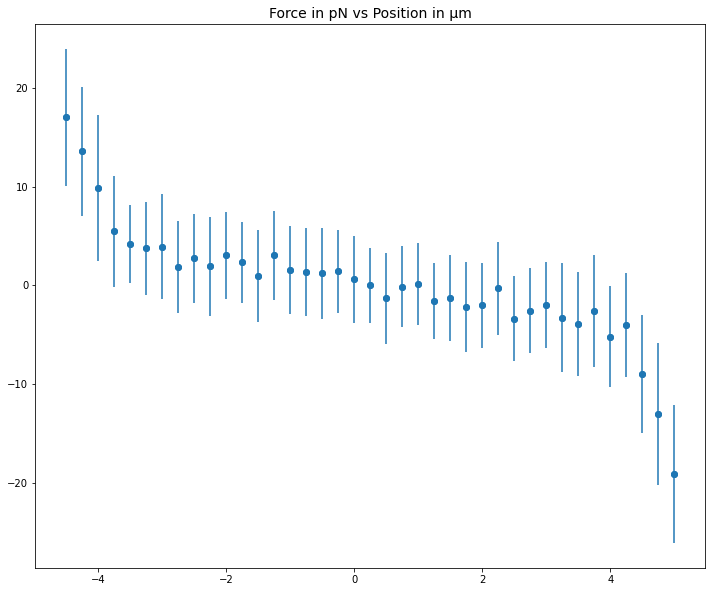

In [32]:
#PLOT FORCE VS POSITION

plt.figure(figsize = (12,10))

plt.scatter(assigned_tweezer,df_total_force_X_mean)
plt.errorbar(assigned_tweezer, df_total_force_X_mean, yerr=df_total_force_X_std, fmt='o')
plt.title("Force in pN vs Position in µm",size = 14)
plt.show()

### <i> <u> Third Part - Vesicule Pulling - Force vs Position </u> </i>

Thanks to the Tweezers we can get the force vs position curve.